# ライブラリのインポート

In [1]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29089 sha256=f2887109f726d34566811ddfd723e35fb863a7b7683f47ad7802fa75a457beb5
  Stored in directory: /root/.cache/pip/wheels/47/51/06/380dc516ea78621870b93ff65527c251afdfdc5fa9d7f4d248
Successfully built ta


In [2]:
import time # 時間を扱うライブラリ
import copy # ファイルをコピーする際に使用するライブラリ
import pandas as pd  # 表データを扱うライブラリ
import numpy as np  # 数値計算用のライブラリ
import matplotlib.pyplot as plt # 可視化用のライブラリ
import seaborn as sns  #　綺麗に可視化することができるライブラリ
import warnings
warnings.filterwarnings('ignore')  # 警告を無視する


### Jupyter Notebookで、pandasの表示行数や表示列数を変更する

In [3]:
#現在の最大表示行数の出力
print(pd.get_option("display.max_rows"))

#最大表示行数の指定（ここでは　１００行を指定）
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

60


### データの中身を確認

In [4]:
df = pd.read_csv("1d_xrp_20211101_20230814.csv")

In [5]:
df = df.reset_index(drop=True).rename(columns={"time":"datetime"})

In [6]:
df.head()

,open,high,low,close,volume,datetime
0,127.101,129.246,122.800,124.783,2.014793e+07,2021-11-01 00:00:00
1,124.817,130.130,124.000,129.074,2.360823e+07,2021-11-02 00:00:00
2,129.200,139.900,128.399,137.800,6.440365e+07,2021-11-03 00:00:00
3,137.800,143.000,132.800,136.823,3.977501e+07,2021-11-04 00:00:00
4,136.822,136.822,129.900,131.950,2.051250e+07,2021-11-05 00:00:00


# バックテストを行う

In [7]:
class EasyBacktest:
    def __init__(self, df, order_lot=1, columns=None):
        self.df = df.copy()
        self.order_lot = order_lot
        self.columns = columns

        self.position = {"qty": 0, "avgEntry": 0}
        self.exec_history = []

    def market_order(self, order_size=None, next_open_price=None):
        if order_size is None:
            order_size = self.order_lot
        if next_open_price is None:
            next_open_price = self.next_open_price

        order = {
            "timestamp": self.current_timestamp,
            "size": order_size,
            "price": next_open_price
        }
        self.exec_history.append(order)
        self.position = self._change_position(order_lot=order_size)

    def _change_position(self, order_lot):
        current_qty = self.position["qty"]
        current_avg = self.position["avgEntry"]
        new_qty = current_qty + order_lot

        if new_qty == 0:
            new_avg = 0
        else:
            if current_qty * order_lot >= 0:
                new_avg = (current_qty * current_avg + order_lot * self.next_open_price) / (current_qty + order_lot)
            else:
                if current_qty >= 0:
                    if new_qty > 0:
                        new_avg = current_avg
                    else:
                        new_avg = self.next_open_price
                else:
                    if new_qty > 0:
                        new_avg = self.next_open_price
                    else:
                        new_avg = current_avg

        self.position["qty"] = new_qty
        self.position["avgEntry"] = new_avg
        return self.position

    def get_column(self, df):
        if self.columns is None:
            return df[["datetime", "close", "open"]]
        return df[["datetime", "close", "open"] + self.columns].reset_index(drop=True)

    def get_position(self):
        return self.position

    def action(self):
        pass

    def do_backtest(self):
        print(" ----   Do Backtest   ----")
        start = time.time()
        # df = self.get_column(self.df) # カラムを制限しても良い

        for i in range(1, len(self.df) - 1):
            self.i = i
            self.close_price = self.df["close"][i]
            self.next_open_price = self.df["high"][i + 1]
            self.current_timestamp = self.df["datetime"][i]

            # ここでaction()メソッドを呼び出して、トレードのロジックを実行する
            self.action()

        print(" ----   finish backtest   ----")
        elapsed_time = time.time() - start
        print(f" ----   elapsed time: {elapsed_time}   ---- ")
        return pd.DataFrame(self.exec_history, columns=["timestamp", "size", "price"])


### profit and lossのグラフを作成

In [8]:
def make_pl(df, comfee=None, initial=1):
    """
    df : pd.DataFrame
        size : float or int sellはマイナス　buyはプラス
        time : unixtime or datetime
        price : float or int
    initial :
        初期資金
    comfee ：
        手数料
    profit and loss を作成
    """

    print(" ----   Make PL Graph   ----")
    start = time.time()
    if len(df) < 2:
        return df, 0
    # それぞれの値をnumpyに変換
    size = df["size"].values
    pct_price = df["price"].pct_change().values

    # 計算用pl(空のarrayを作成)
    PLs = np.zeros(len(df))
    # 積み上げposition
    cumsum_position_size = np.cumsum(size)
    for i in range(1,len(df)):
        #　手数料がある場合
        if comfee:
            PLs[i] = pct_price[i]*cumsum_position_size[i - 1] - abs(comfee*cumsum_position_size[i - 1])
        else:
            PLs[i] = pct_price[i]*cumsum_position_size[i - 1]
    # 一回の損益
    df["PL"] = PLs
    # 念のためコピーして初期資金分を足しておく
    tmp_PLs = copy.copy(PLs)
    tmp_PLs[0] += initial
    # 累積損益
    PL_graph = np.cumsum(tmp_PLs)
    df["PL_graph"] = PL_graph
    # 勝率
    tmp = PLs > 0
    tmp = tmp.sum()
    win_rate = tmp/len(PLs)
    # 実現損益
    profit = PL_graph[-1]-initial
    # 平均損益
    avg_pl = profit/len(PLs)
    df["cumsum_position"] = cumsum_position_size
    print(f"取引回数:{len(PLs)} 実現損益:{profit} 勝率:{win_rate} 平均損益{avg_pl} ")
    elapsed_time = time.time() - start
    print(f" ----   elapsed time: {elapsed_time}   ---- ")
    return df, profit


 ----   Do Backtest   ----
 ----   finish backtest   ----
 ----   elapsed time: 0.018525123596191406   ---- 
 ----   Make PL Graph   ----
取引回数:82 実現損益:1.2177419384241723 勝率:0.21951219512195122 平均損益0.014850511444197224 
 ----   elapsed time: 0.0075113773345947266   ---- 


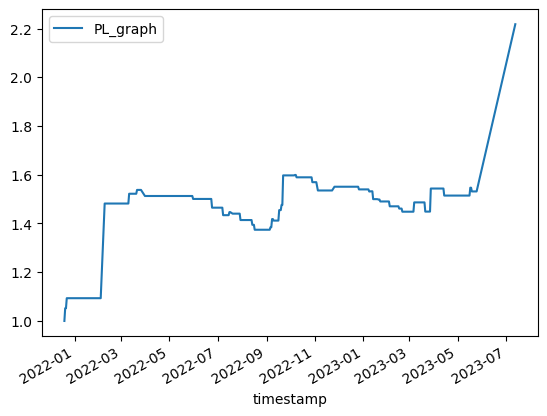

ストリーミング出力は最後の 5000 行に切り捨てられました。
 ----   Do Backtest   ----
 ----   finish backtest   ----
 ----   elapsed time: 0.02504563331604004   ---- 
 ----   Make PL Graph   ----
取引回数:82 実現損益:1.2177419384241723 勝率:0.21951219512195122 平均損益0.014850511444197224 
 ----   elapsed time: 0.0015614032745361328   ---- 
 ----   Do Backtest   ----
 ----   finish backtest   ----
 ----   elapsed time: 0.018639087677001953   ---- 
 ----   Make PL Graph   ----
取引回数:72 実現損益:1.0431010935096499 勝率:0.1527777777777778 平均損益0.014487515187634026 
 ----   elapsed time: 0.0011739730834960938   ---- 
 ----   Do Backtest   ----
 ----   finish backtest   ----
 ----   elapsed time: 0.018682003021240234   ---- 
 ----   Make PL Graph   ----
取引回数:52 実現損益:1.4008145284429858 勝率:0.17307692307692307 平均損益0.02693874093159588 
 ----   elapsed time: 0.001402139663696289   ---- 
 ----   Do Backtest   ----
 ----   finish backtest   ----
 ----   elapsed time: 0.019138336181640625   ---- 
 ----   Make PL Graph   ----
取引回数:48 実現損益:1.179600

In [9]:
import logging

# loggingの初期設定
logging.basicConfig(level=logging.INFO)

class RangeBreakoutStrategy(EasyBacktest):

    # 初期化メソッド
    def __init__(self, df, order_lot=1, time_frame=30, price_diff_percent=1,
                 capital_use_percent=1, exit_profit_percent=0.065, exit_loss_percent=0.001):
        df_copy = df.copy()  # データフレームをコピー
        self.set_time_frame_high_low(df_copy, time_frame)  # 時間枠内の高値・安値を計算
        super().__init__(df_copy, order_lot)  # 親クラスの初期化メソッドを呼び出す
        # 下記は、各種属性の初期化
        self.time_frame = time_frame
        self.price_diff_percent = price_diff_percent
        self.capital_use_percent = capital_use_percent
        self.exit_profit_percent = exit_profit_percent
        self.exit_loss_percent = exit_loss_percent

        # capital属性の追加
        # self.capital = 100000  # 例: 100,000として初期化 (適切な初期値に変更してください)

    # 静的メソッド: 時間枠内の高値・安値を計算
    @staticmethod
    def set_time_frame_high_low(df, time_frame):
        df['high_max'] = df['high'].rolling(window=time_frame).max()  # 時間枠内の最高値
        df['low_min'] = df['low'].rolling(window=time_frame).min()    # 時間枠内の最低値

    # アクションメソッド: トレードロジックの定義
    def action(self):
        high_max = self.df['high_max'][self.i]  # 現在の高値
        low_min = self.df['low_min'][self.i]    # 現在の安値
        next_open = self.df['high'][self.i+1] if self.i+1 < len(self.df) else 0  # 次のオープン価格

        position = self.get_position()  # 現在のポジション取得

        # デバッグログ追加
        logging.info(f"Index: {self.i}, High Max: {high_max}, Low Min: {low_min}, Next Open: {next_open}, Position: {position}")

        # エントリー条件
        if position["qty"] == 0:
            if 1 - (low_min/high_max) <= self.price_diff_percent and next_open > high_max:
               # order_qty = (self.capital * self.capital_use_percent) / next_open
                self.market_order()
                # エントリーログ
                logging.info(f"Entered at index {self.i}, Order Quantity: {self.order_lot}")
        # イグジット条件
        elif position["qty"] > 0:
            entry_price = position["avgEntry"]
            if self.df['close'][self.i] >= entry_price * (1 + self.exit_profit_percent):
                self.market_order(order_size=-position["qty"])  # ポジションクローズ
                # イグジットログ（利益確定）
                logging.info(f"Exit (Profit) at index {self.i}")
            elif self.df['close'][self.i] <= entry_price * (1 - self.exit_loss_percent):
                self.market_order(order_size=-position["qty"])  # ポジションクローズ
                # イグジットログ（損切り）
                logging.info(f"Exit (Loss) at index {self.i}")

# インスタンス化: RangeBreakoutStrategy
strategy = RangeBreakoutStrategy(df=df, order_lot=1, time_frame=10, price_diff_percent=0.3,
                                 capital_use_percent=1, exit_profit_percent=0.3, exit_loss_percent=0.01)
strategy.do_backtest()  # バックテスト実行

pd.DataFrame(strategy.exec_history).to_csv('test2.csv')

# PLグラフ生成
pl, profit = make_pl(pd.DataFrame(strategy.exec_history), comfee=0.0024)
if len(pl) > 2:
    pl["timestamp"] = pd.to_datetime(pl["timestamp"])  # タイムスタンプの変換
    pl.plot(x="timestamp", y="PL_graph")  # PLグラフ描画
    plt.show()  # グラフ表示

pl.to_csv('test.csv')

# ... [既存のコード]

def optimize_parameters(df):
    # 利益と損失のパーセンテージのリストを定義する
    profit_percentages = [i/1000 for i in range(10, 500, 10)]  # 例: 0.005, 0.01, ..., 0.095
    loss_percentages = [i/1000 for i in range(10, 500, 10)]     # 例: 0.001, 0.002, ..., 0.009

    best_profit = float('-inf')  # 最適な利益の初期値を非常に小さい値に設定
    best_params = (None, None)  # 最適なパラメータの組み合わせの初期値を設定

    # それぞれの組み合わせに対してバックテストを実行する
    for exit_profit_percent in profit_percentages:
        for exit_loss_percent in loss_percentages:
            strategy = RangeBreakoutStrategy(df=df, order_lot=1, time_frame=10, price_diff_percent=0.3,
                                             capital_use_percent=1, exit_profit_percent=exit_profit_percent, exit_loss_percent=exit_loss_percent)
            strategy.do_backtest()
            pl, profit = make_pl(pd.DataFrame(strategy.exec_history), comfee=0.0024)
            if profit > best_profit:
                best_profit = profit
                best_params = (exit_profit_percent, exit_loss_percent)

    return best_params

best_exit_profit_percent, best_exit_loss_percent = optimize_parameters(df)
print(f"Best exit_profit_percent: {best_exit_profit_percent}")
print(f"Best exit_loss_percent: {best_exit_loss_percent}")


 ----   Do Backtest   ----
 ----   finish backtest   ----
 ----   elapsed time: 0.023607969284057617   ---- 
 ----   Make PL Graph   ----
取引回数:46 実現損益:1.7458365862935836 勝率:0.1956521739130435 平均損益0.03795296926725182 
 ----   elapsed time: 0.0013561248779296875   ---- 


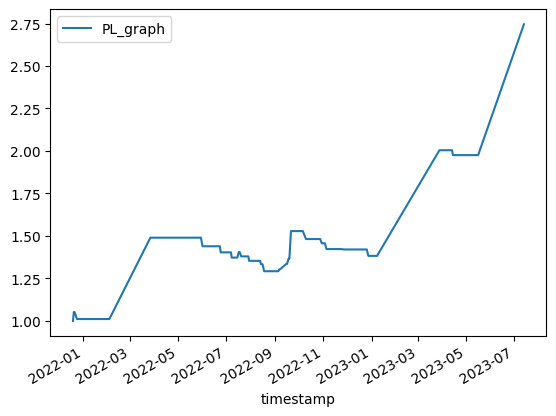

In [11]:
import logging

# loggingの初期設定
logging.basicConfig(level=logging.INFO)

class RangeBreakoutStrategy(EasyBacktest):

    # 初期化メソッド
    def __init__(self, df, order_lot=1, time_frame=30, price_diff_percent=1,
                 capital_use_percent=1, exit_profit_percent=0.065, exit_loss_percent=0.001):
        df_copy = df.copy()  # データフレームをコピー
        self.set_time_frame_high_low(df_copy, time_frame)  # 時間枠内の高値・安値を計算
        super().__init__(df_copy, order_lot)  # 親クラスの初期化メソッドを呼び出す
        # 下記は、各種属性の初期化
        self.time_frame = time_frame
        self.price_diff_percent = price_diff_percent
        self.capital_use_percent = capital_use_percent
        self.exit_profit_percent = exit_profit_percent
        self.exit_loss_percent = exit_loss_percent

        # capital属性の追加
        # self.capital = 100000  # 例: 100,000として初期化 (適切な初期値に変更してください)

    # 静的メソッド: 時間枠内の高値・安値を計算
    @staticmethod
    def set_time_frame_high_low(df, time_frame):
        df['high_max'] = df['high'].rolling(window=time_frame).max()  # 時間枠内の最高値
        df['low_min'] = df['low'].rolling(window=time_frame).min()    # 時間枠内の最低値

    # アクションメソッド: トレードロジックの定義
    def action(self):
        high_max = self.df['high_max'][self.i]  # 現在の高値
        low_min = self.df['low_min'][self.i]    # 現在の安値
        next_open = self.df['high'][self.i+1] if self.i+1 < len(self.df) else 0  # 次のオープン価格

        position = self.get_position()  # 現在のポジション取得

        # デバッグログ追加
        logging.info(f"Index: {self.i}, High Max: {high_max}, Low Min: {low_min}, Next Open: {next_open}, Position: {position}")

        # エントリー条件
        if position["qty"] == 0:
            if 1 - (low_min/high_max) <= self.price_diff_percent and next_open > high_max:
               # order_qty = (self.capital * self.capital_use_percent) / next_open
                self.market_order()
                # エントリーログ
                logging.info(f"Entered at index {self.i}, Order Quantity: {self.order_lot}")
        # イグジット条件
        elif position["qty"] > 0:
            entry_price = position["avgEntry"]
            if self.df['close'][self.i] >= entry_price * (1 + self.exit_profit_percent):
                self.market_order(order_size=-position["qty"])  # ポジションクローズ
                # イグジットログ（利益確定）
                logging.info(f"Exit (Profit) at index {self.i}")
            elif self.df['close'][self.i] <= entry_price * (1 - self.exit_loss_percent):
                self.market_order(order_size=-position["qty"])  # ポジションクローズ
                # イグジットログ（損切り）
                logging.info(f"Exit (Loss) at index {self.i}")

# インスタンス化: RangeBreakoutStrategy
strategy = RangeBreakoutStrategy(df=df, order_lot=1, time_frame=10, price_diff_percent=0.3,
                                 capital_use_percent=1, exit_profit_percent=0.36, exit_loss_percent=0.03)
strategy.do_backtest()  # バックテスト実行

# PLグラフ生成
pl, profit = make_pl(pd.DataFrame(strategy.exec_history), comfee=0.0024)
if len(pl) > 2:
    pl["timestamp"] = pd.to_datetime(pl["timestamp"])  # タイムスタンプの変換
    pl.plot(x="timestamp", y="PL_graph")  # PLグラフ描画
    plt.show()  # グラフ表示